# Expected variants
This script determines the expected number of variants per transcript

## Preliminaries

### Install libraries to worker

In [62]:
! conda install statsmodels -y
! conda install scikit-learn -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



### Import modules

In [174]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import seaborn as sns
from scipy import stats as _stats
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest
from sklearn.metrics import r2_score

sns.set_context("talk")

## Load datasets

In [3]:
# Define VCF headers and datatypes.
_header = ["chr", "pos", "id", "ref", "alt", "qual", "filter", "info"]

datatypes = defaultdict(lambda: "str")
datatypes.update({"pos": np.int32, "ac": np.int32, "an": np.int32})

In [4]:
# Retreive observed variants
obs = pd.read_csv(
    "../data/all_pass_snvs.txt",
    sep="\t",
    header=None,
    names=_header + ["ac", "an"],
    usecols=["chr", "pos", "ref", "alt", "ac", "an"],
    dtype=datatypes,
).assign(obs=1)

In [7]:
# Retreive VEP annotations of all possible SNVs
vep = pd.read_csv(
    "../data/vep_cds_all_possible_snvs.vcf",
    sep="\t",
    comment="#",
    header=None,
    names=_header,
    dtype=datatypes,
    usecols=["chr", "pos", "ref", "alt", "info"],
)

In [11]:
# Get enst
vep["enst"] = pd.Series([x.split("|", 3)[2] for x in vep["info"]])

In [14]:
# Get csq
syn = pd.Series(["synonymous" in x for x in vep["info"]])
mis = pd.Series(["missense" in x for x in vep["info"]])
non = pd.Series(["stop_gained" in x for x in vep["info"]])

vep.loc[syn, "csq"] = "synonymous"
vep.loc[mis, "csq"] = "missense"
vep.loc[non, "csq"] = "nonsense"

vep = vep.drop("info", axis=1).dropna()  # Keep only syn/mis/non variants

In [16]:
# Trinucleotide contexts
tri = pd.read_csv(
    "../data/cds_trinucleotide_contexts.tsv", sep="\t", dtype=datatypes
)

In [17]:
# gnomAD methylation data
meth = (pd.read_csv("../data/grch38_cpg_methylation.tsv", 
                    sep="\t",
                    header=0,
                    names=["ix","chr","pos","alleles","lvl"],
                    usecols=["chr","pos","lvl"],
                   )
       )

In [18]:
# Mutation rates
mu = pd.read_csv(
    "../data/gnomad_nc_mutation_rates.tsv",
    sep="\t",
    names=["tri", "ref", "alt", "lvl", "variant_type", "mu", "pos", "obs", "po", "ppo",],
    header=0,
    usecols=["tri", "ref", "alt", "lvl", "mu", "variant_type"],
)

# Mutation rates are only available for 32 codons. We need to reverse-complement for the remainder.
complement = {"A": "T", "C": "G", "G": "C", "T": "A"}
# Replace ref and alt alleles
_mu = mu.copy().replace(complement)
# Reverse-complement trinucleotide contexts
_mu["tri"] = pd.Series(["".join([complement[y] for y in x])[::-1] for x in mu.tri])
mu = pd.concat([mu, _mu])

## Merge annotations

In [22]:
# Merge VEP, context, and observed variant annotations
df = vep.merge(tri, how="left")
df = df.merge(obs, how="left").fillna(0)

In [30]:
# Merge methylation annotations
variant_types = mu[["tri", "ref", "alt", "variant_type"]].drop_duplicates()
df = df.merge(variant_types, how="left")
df = df.merge(meth, how="left")

# All non-CpG sites have lvl 0
df.loc[df["variant_type"] != "CpG", "lvl"] = 0
df.lvl = df.lvl.astype(int)

# Merge with mutability data
df = df.merge(mu, how="left")

## Expectation model

In [39]:
# Load summary statistics
stats = pd.read_csv("../outputs/mutational_model_stats.tsv", sep="\t")

# Exclude saturated contexts
stats_nonsat = stats[stats["obs"] != 1].copy()

### Fit the model

In [40]:
# A function to retrieve the standard error of a proportion
def sem(p, n): return np.sqrt((p*(1-p))/n)

In [41]:
# Get an exponential regression equation 
# Weighted by 1 / sem("obs"), as per gnomAD paper
fit = np.polyfit(stats_nonsat["mu"], np.log(1 - stats_nonsat["obs"]), 1, w=(1/sem(stats_nonsat["obs"], stats_nonsat["pos"])))

# Create a polynomial evaluator
p = np.poly1d(fit)

# Fit the model to estimate the observed proportion
stats_nonsat["fit_obs"] = 1 - np.exp(p(stats_nonsat["mu"]))

# R2 for "obs" vs "fit_obs"
print(f'R2 = {np.round(r2_score(stats_nonsat["obs"], stats_nonsat["fit_obs"]), 5)} for "obs" vs "fit_obs"')

R2 = 0.9939 for "obs" vs "fit_obs"


# Summary statistics

In [50]:
# OE statistics
dfg = (
    df.groupby(["enst", "csq"])
    .agg(
        n_pos=("pos", "count"),
        n_obs=("obs", "sum"),
        mu=("mu", "mean"),
    )
    .assign(
        prop_obs=lambda x: x["n_obs"] / x["n_pos"],
        se_prop_obs=lambda x: np.sqrt((x["prop_obs"] * (1 - x["prop_obs"])) / x["n_pos"]),
        prop_exp=lambda x: 1 - np.exp(p(x["mu"])),
        se_prop_exp=lambda x: np.sqrt((x["prop_exp"] * (1 - x["prop_exp"])) / x["n_pos"]),
        n_exp=lambda x: np.round(x["n_pos"] * x["prop_exp"], 2),
        oe=lambda x: x["n_obs"] / x["n_exp"],
        oe_ci_upper=lambda x: (x["prop_obs"] + _stats.norm.ppf(0.975) * (x["se_prop_obs"])) / x["prop_exp"],
        ee_ci_lower=lambda x: (x["prop_exp"] - _stats.norm.ppf(0.975) * (x["se_prop_exp"])) / x["prop_exp"],
        oe_diff=lambda x: (x["oe"] - x["ee_ci_lower"]),
    )
    .reset_index()
)
# Z scores and p-values
dfg["z"] = dfg.apply(
    lambda x: (
        proportions_ztest(
            x["n_obs"],
            x["n_pos"],
            x["prop_exp"],
            alternative="smaller",
            prop_var=x["prop_exp"],
        )[0]
    ),
    axis=1,
)
dfg["p"] = dfg.apply(
    lambda x: proportions_ztest(
        x["n_obs"],
        x["n_pos"],
        x["prop_exp"],
        alternative="smaller",
        prop_var=x["prop_exp"],
    )[1],
    axis=1,
)

In [54]:
dfg.to_csv("../outputs/expected_variants_stats.tsv", sep="\t", index=False)

## Plots

### Expected and observed variants per transcript

Text(0.5, 0.98, 'Variants per transcript')

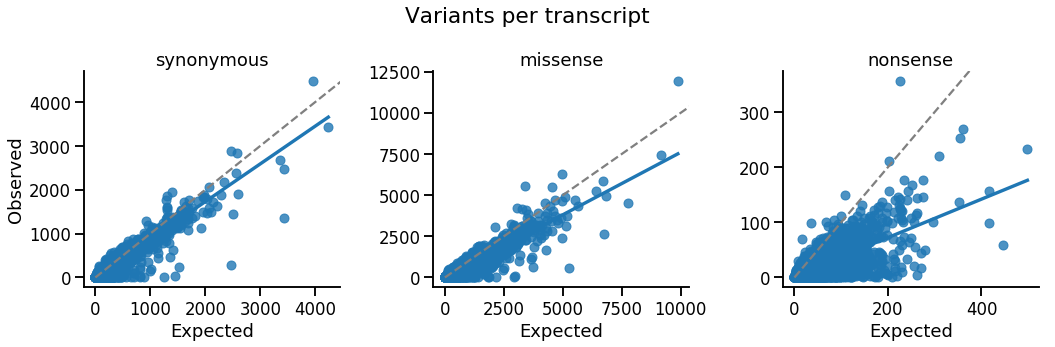

In [188]:
# Plot number observed vs number expected per transcript
# Exclude TTN for visual clarity
g = sns.lmplot(
    data=dfg[dfg.enst != "ENST00000589042"],
    x="n_exp",
    y="n_obs",
    col="csq",
    col_order=["synonymous", "missense", "nonsense"],
    sharex=False,
    sharey=False,
    ci=None,
    robust=True
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Expected", "Observed")
for ax in g.axes[0]:
    ax.add_artist(lines.Line2D([0,10**6],[0,10**6], color="grey", linestyle="--"))
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Variants per transcript")

## O/E distributions

ValueError: could not convert string to float: 'ENST00000000233'

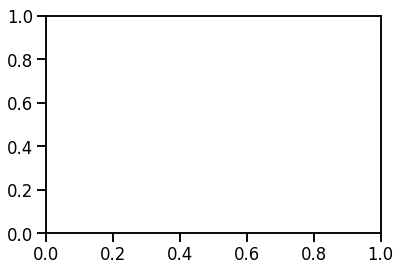

In [193]:
# Plot distributions of O/E ratio per transcript
g = sns.displot(
    data=dfg,
    kind="kde",
    x="oe",
    col="csq",
    col_order=["synonymous", "missense", "nonsense"],
    sharex=False,
    sharey=False,
    height=4,
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("O/E")
g.set(xlim=(0, 2))
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("O/E ratio per transcript");

## O/E upper confidence interval distribution

In [ ]:
# Plot distributions of O/E upper confidence interval per transcript
g = sns.displot(
    data=dfg,
    kind="kde",
    x="oe_ci_upper",
    col="csq",
    col_order=["synonymous", "missense", "nonsense"],
    facet_kws={"sharex": False, "sharey": False},
    height=4,
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("O/E upper 95% CI")
g.set(xlim=(0, 2))
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("O/E upper 95% confidence interval per transcript");

## O/E difference from E/E lower confidence interval

In [ ]:
# Plot distributions of O/E difference from E/E lower 95% confidence interval per transcript
g = sns.displot(
    data=dfg,
    kind="kde",
    x="oe_diff",
    col="csq",
    col_order=["synonymous", "missense", "nonsense"],
    facet_kws={"sharex": True, "sharey": False},
    height=4,
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("O/E difference")
g.set(xlim=(-1, 1))
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("O/E difference from E/E lower 95% confidence interval per transcript");

## N expected by consequence

In [ ]:
# Plot distributions of n_exp per transcript
sns.set_context("talk")
g = sns.displot(
    data=dfg,
    kind="ecdf",
    x="n_exp",
    col="csq",
    col_order=["synonymous", "missense", "nonsense"],
    facet_kws={"sharex": False, "sharey": False},
    height=4,
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Expected")

# Set x-axis limits
g.axes[0, 0].set_xlim(0, 200)
g.axes[0, 1].set_xlim(0, 500)
g.axes[0, 2].set_xlim(0, 20)
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Expected variants per transcript");

## One-sample Z score

In [ ]:
# Plot distributions of one-sample Z scores per transcript
sns.set_context("talk")
g = sns.displot(
    data=dfg,
    kind="kde",
    x="z",
    col="csq",
    col_order=["synonymous", "missense", "nonsense"],
    facet_kws={"sharex": True, "sharey": False},
    height=4,
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Z")
g.set(xlim=(-10, 5))
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("One-sample Z-scores per transcript");

## P-values

In [ ]:
# Plot distributions of p-values per transcript
sns.set_context("talk")
g = sns.displot(
    data=dfg,
    kind="kde",
    x="p",
    col="csq",
    col_order=["synonymous", "missense", "nonsense"],
    facet_kws={"sharex": True, "sharey": False},
    height=4,
)
g.set_titles(col_template="{col_name}")
g.set_axis_labels("p")
g.set(xscale="log")
g.set(xlim=(0, 1))
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("p-values per transcript");